In [3]:
!pip install nb-black

In [4]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [5]:
import sys

sys.path.insert(0, "../")

## Dataset

In [6]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [7]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [30]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ToNumpy(),
    BandPass(
        attenuation=attenuation,
        lowcut=lowcut,
        highcut=highcut,
        fs=fs,
        interval=interval,
    ),
    ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    # ExpandDim(dim=2),
    # ExpandDim(dim=2),
    Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [31]:
wave, label = ds[0]
print(wave.min(), wave.max())
print(wave.shape)

tensor(-8.1779, dtype=torch.float64) tensor(8.1676, dtype=torch.float64)
torch.Size([1, 22, 1, 9, 1001])


In [32]:
for i in tqdm(range(len(ds))):
    wave, label = ds[i]
    # print(wave.min(), wave.max())
    # print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")

# Batch, channel, window

  0%|          | 0/5184 [00:00<?, ?it/s]

In [33]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [34]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Get CSP Weights

In [35]:
from cspnn.csp import CSP as CSP_base

In [40]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

csp = CSP_base(list(range(1, 5)), num_bands=9, num_windows=1)

In [38]:
signale = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signale.append(sig)
    label.append(lbl["label"])
signale = torch.vstack(signale)
label = torch.stack(label)

  0%|          | 0/2592 [00:00<?, ?it/s]

In [39]:
signale.size(), label.size()

(torch.Size([2592, 22, 1, 9, 1001]), torch.Size([2592]))

In [41]:
weights = csp.calculate_weights(
    signals=signale.cpu().detach().numpy(), labels=label.cpu().detach().numpy()
)

In [42]:
weights.keys()

dict_keys(['label-1_band-0_window-0', 'label-1_band-1_window-0', 'label-1_band-2_window-0', 'label-1_band-3_window-0', 'label-1_band-4_window-0', 'label-1_band-5_window-0', 'label-1_band-6_window-0', 'label-1_band-7_window-0', 'label-1_band-8_window-0', 'label-2_band-0_window-0', 'label-2_band-1_window-0', 'label-2_band-2_window-0', 'label-2_band-3_window-0', 'label-2_band-4_window-0', 'label-2_band-5_window-0', 'label-2_band-6_window-0', 'label-2_band-7_window-0', 'label-2_band-8_window-0', 'label-3_band-0_window-0', 'label-3_band-1_window-0', 'label-3_band-2_window-0', 'label-3_band-3_window-0', 'label-3_band-4_window-0', 'label-3_band-5_window-0', 'label-3_band-6_window-0', 'label-3_band-7_window-0', 'label-3_band-8_window-0', 'label-4_band-0_window-0', 'label-4_band-1_window-0', 'label-4_band-2_window-0', 'label-4_band-3_window-0', 'label-4_band-4_window-0', 'label-4_band-5_window-0', 'label-4_band-6_window-0', 'label-4_band-7_window-0', 'label-4_band-8_window-0'])

## Model

In [43]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [44]:
import torch.optim as optim

In [45]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [49]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=9, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [50]:
signals = torch.empty((10, 22, 1, 9, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 36, 22]))

In [54]:
net.conv1.load_csp_weights(weights=weights, csp_template=csp.template)

## Train Loop

In [55]:
net = net.cuda()

In [56]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


81it [00:12,  6.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4088079237643583


Train -  [0.25, 0.0, 0.4901912103718945, 0.25, tensor(1.4059)]
Validation -  [0.25, 0.0, 0.4905771120700605, 0.25, tensor(1.4059)]

Epoch  1


81it [00:12,  6.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4072239840472187


Train -  [0.25, 0.0, 0.5059253623050348, 0.25, tensor(1.4162)]
Validation -  [0.25, 0.0, 0.4908510834222426, 0.25, tensor(1.4162)]

Epoch  2


81it [00:12,  6.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.417177606511999


Train -  [0.25, 0.0, 0.49066909738098874, 0.25, tensor(1.4047)]
Validation -  [0.25, 0.0, 0.4932797139346137, 0.25, tensor(1.4047)]

Epoch  3


81it [00:12,  6.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4069276179796384


Train -  [0.25, 0.0, 0.4884599614832596, 0.25, tensor(1.4014)]
Validation -  [0.25, 0.0, 0.49364904438474827, 0.25, tensor(1.4014)]

Epoch  4


81it [00:12,  6.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4024105454668587


Train -  [0.25, 0.0, 0.49175376990931263, 0.25, tensor(1.4054)]
Validation -  [0.25, 0.0, 0.4964178320123965, 0.25, tensor(1.4054)]

Epoch  5


81it [00:13,  6.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.404954774880115


Train -  [0.25, 0.0, 0.4899006677716811, 0.25, tensor(1.3982)]
Validation -  [0.25, 0.0, 0.4925570289081949, 0.25, tensor(1.3982)]

Epoch  6


81it [00:13,  6.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4024173080185314


Train -  [0.25, 0.0, 0.492369585270284, 0.25, tensor(1.4019)]
Validation -  [0.25, 0.0, 0.49934012694965196, 0.25, tensor(1.4019)]

Epoch  7


81it [00:12,  6.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4126844244238772


Train -  [0.25, 0.0, 0.490116093996088, 0.25, tensor(1.4046)]
Validation -  [0.25, 0.0, 0.4924097730274857, 0.25, tensor(1.4046)]

Epoch  8


81it [00:12,  6.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4089584247565563


Train -  [0.25, 0.0, 0.4897235439529035, 0.25, tensor(1.4079)]
Validation -  [0.25, 0.0, 0.49447492760249967, 0.25, tensor(1.4079)]

Epoch  9


81it [00:12,  6.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.406176565605917


Train -  [0.25, 0.0, 0.49059090490524815, 0.25, tensor(1.4045)]
Validation -  [0.25, 0.0, 0.496860988860946, 0.25, tensor(1.4045)]

Epoch  10


81it [00:13,  6.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4051607611738606


Train -  [0.25, 0.0, 0.4982650796372504, 0.25, tensor(1.4046)]
Validation -  [0.25, 0.0, 0.49552238924452574, 0.25, tensor(1.4046)]

Epoch  11


81it [00:12,  6.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4018756254219715


Train -  [0.25, 0.0, 0.4914425876708327, 0.25, tensor(1.4003)]
Validation -  [0.25, 0.0, 0.49451342846618906, 0.25, tensor(1.4003)]

Epoch  12


81it [00:13,  6.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3965323044929976


Train -  [0.25, 0.0, 0.4924675243230199, 0.25, tensor(1.3932)]
Validation -  [0.25, 0.0, 0.49179921680511096, 0.25, tensor(1.3932)]

Epoch  13


81it [00:12,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4005701762658578


Train -  [0.25, 0.0, 0.49557001917898696, 0.25, tensor(1.3966)]
Validation -  [0.25, 0.0, 0.49651587029416244, 0.25, tensor(1.3966)]

Epoch  14


81it [00:12,  6.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4060868054260443


Train -  [0.25, 0.0, 0.49068209638393534, 0.25, tensor(1.3962)]
Validation -  [0.25, 0.0, 0.4946793394045623, 0.25, tensor(1.3962)]

Epoch  15


81it [00:12,  6.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4041332595142317


Train -  [0.25, 0.0, 0.49511068799852664, 0.25, tensor(1.4034)]
Validation -  [0.25, 0.0, 0.49651249650713813, 0.25, tensor(1.4034)]

Epoch  16


81it [00:13,  6.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4028598070144653


Train -  [0.25, 0.0, 0.4966203584628867, 0.25, tensor(1.4013)]
Validation -  [0.25, 0.0, 0.4965698508865518, 0.25, tensor(1.4013)]

Epoch  17


81it [00:13,  6.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4037636003376526


Train -  [0.25, 0.0, 0.49161415466392316, 0.25, tensor(1.3973)]
Validation -  [0.25, 0.0, 0.4957746294391099, 0.25, tensor(1.3973)]

Epoch  18


81it [00:13,  6.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4072797813533264


Train -  [0.25, 0.0, 0.4936654171747193, 0.25, tensor(1.4098)]
Validation -  [0.25, 0.0, 0.49705389009551393, 0.25, tensor(1.4098)]

Epoch  19


81it [00:12,  6.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3952814723238534


Train -  [0.25, 0.0, 0.4939420677107148, 0.25, tensor(1.3972)]
Validation -  [0.25, 0.0, 0.497963621843723, 0.25, tensor(1.3972)]

Epoch  20


81it [00:13,  6.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4062599002579113


Train -  [0.25, 0.0, 0.4964028484288472, 0.25, tensor(1.3953)]
Validation -  [0.25, 0.0, 0.5008798638101408, 0.25, tensor(1.3953)]

Epoch  21


81it [00:12,  6.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3967140957161233


Train -  [0.25, 0.0, 0.4897828829129198, 0.25, tensor(1.4000)]
Validation -  [0.25, 0.0, 0.5029170357986588, 0.25, tensor(1.4000)]

Epoch  22


81it [00:13,  6.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4007426838815948


Train -  [0.25, 0.0, 0.4931198559670782, 0.25, tensor(1.3920)]
Validation -  [0.25, 0.0, 0.5069490089798303, 0.25, tensor(1.3920)]

Epoch  23


81it [00:12,  6.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.399346148526227


Train -  [0.25, 0.0, 0.4945267251562262, 0.25, tensor(1.3888)]
Validation -  [0.25, 0.0, 0.5005604455621603, 0.25, tensor(1.3888)]

Epoch  24


81it [00:13,  6.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.397674897570669


Train -  [0.25, 0.0, 0.4925979112686074, 0.25, tensor(1.3936)]
Validation -  [0.25, 0.0, 0.4927817826614338, 0.25, tensor(1.3936)]

Epoch  25


81it [00:13,  6.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.392794054231526


Train -  [0.25, 0.0, 0.4920461978610984, 0.25, tensor(1.3932)]
Validation -  [0.25, 0.0, 0.4983078473492354, 0.25, tensor(1.3932)]

Epoch  26


81it [00:13,  6.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.397654629048006


Train -  [0.25, 0.0, 0.49295344888355436, 0.25, tensor(1.3966)]
Validation -  [0.25, 0.0, 0.5011567128041965, 0.25, tensor(1.3966)]

Epoch  27


81it [00:13,  6.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3960419216273743


Train -  [0.25, 0.0, 0.4954415175849718, 0.25, tensor(1.4059)]
Validation -  [0.25, 0.0, 0.49935511053320125, 0.25, tensor(1.4059)]

Epoch  28


81it [00:13,  6.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3974000495157124


Train -  [0.25, 0.0, 0.4972463944139613, 0.25, tensor(1.3903)]
Validation -  [0.25, 0.0, 0.5040422930003048, 0.25, tensor(1.3903)]

Epoch  29


81it [00:12,  6.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3974677015233923


Train -  [0.25, 0.0, 0.49964247780445054, 0.25, tensor(1.3883)]
Validation -  [0.25, 0.0, 0.505130240086623, 0.25, tensor(1.3883)]

Epoch  30


81it [00:13,  6.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3981774515575833


Train -  [0.25, 0.0, 0.4981414402657115, 0.25, tensor(1.3917)]
Validation -  [0.25, 0.0, 0.5010260281715185, 0.25, tensor(1.3917)]

Epoch  31


81it [00:13,  6.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4035311436947482


Train -  [0.25, 0.0, 0.5012778714499821, 0.25, tensor(1.4215)]
Validation -  [0.25, 0.0, 0.5009979463559925, 0.25, tensor(1.4215)]

Epoch  32


81it [00:12,  6.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3994423813290067


Train -  [0.25, 0.0, 0.4998105717814866, 0.25, tensor(1.3975)]
Validation -  [0.25, 0.0, 0.5038931517680231, 0.25, tensor(1.3975)]

Epoch  33


81it [00:12,  6.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4058904059139299


Train -  [0.25, 0.0, 0.49607509494233604, 0.25, tensor(1.4136)]


81it [00:12,  6.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3960145314534504


Train -  [0.25, 0.0, 0.5094868906543717, 0.25, tensor(1.3922)]
Validation -  [0.25, 0.0, 0.5009136016803841, 0.25, tensor(1.3922)]

Epoch  37


81it [00:13,  6.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4044550039150097


Train -  [0.25, 0.0, 0.5090844177081746, 0.25, tensor(1.4017)]
Validation -  [0.25, 0.0, 0.5049125315945232, 0.25, tensor(1.4017)]

Epoch  38


81it [00:12,  6.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3944990517180642


Train -  [0.25, 0.0, 0.5088453749745974, 0.25, tensor(1.3897)]
Validation -  [0.25, 0.0, 0.5101451760402378, 0.25, tensor(1.3897)]

Epoch  39


81it [00:13,  6.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3978813018327878


Train -  [0.25, 0.0, 0.4975620419587969, 0.25, tensor(1.3955)]
Validation -  [0.25, 0.0, 0.49383896874841227, 0.25, tensor(1.3955)]

Epoch  40


81it [00:13,  6.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3958797955218656


Train -  [0.25, 0.0, 0.503015371767515, 0.25, tensor(1.4136)]
Validation -  [0.25, 0.0, 0.5027612462213586, 0.25, tensor(1.4136)]

Epoch  41


81it [00:13,  6.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4209031057946475


Train -  [0.25, 0.0, 0.5059707099718032, 0.25, tensor(1.4743)]
Validation -  [0.25, 0.0, 0.5062080658118682, 0.25, tensor(1.4743)]

Epoch  42


81it [00:12,  6.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4270354980303916


Train -  [0.25, 0.0, 0.5051078143258142, 0.25, tensor(1.4263)]
Validation -  [0.25, 0.0, 0.5040458652453894, 0.25, tensor(1.4263)]

Epoch  43


81it [00:13,  6.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4211482839819827


Train -  [0.25, 0.0, 0.5152262977569476, 0.25, tensor(1.4009)]
Validation -  [0.25, 0.0, 0.5042447202217649, 0.25, tensor(1.4009)]

Epoch  44


81it [00:12,  6.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3976785180009441


Train -  [0.25, 0.0, 0.5067828003543667, 0.25, tensor(1.3938)]
Validation -  [0.25, 0.0, 0.5070165839493471, 0.25, tensor(1.3938)]

Epoch  45


81it [00:12,  6.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3963717796184398


Train -  [0.25, 0.0, 0.5210557055898491, 0.25, tensor(1.4068)]
Validation -  [0.25, 0.0, 0.5067272320974953, 0.25, tensor(1.4068)]

Epoch  46


81it [00:13,  6.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4027070469326444


Train -  [0.25, 0.0, 0.52171012104354, 0.25, tensor(1.3888)]
Validation -  [0.25, 0.0, 0.5070465511164457, 0.25, tensor(1.3888)]

Epoch  47


81it [00:12,  6.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3948918286664986


Train -  [0.25, 0.0, 0.5171898418051111, 0.25, tensor(1.3890)]
Validation -  [0.25, 0.0, 0.5075523214830056, 0.25, tensor(1.3890)]

Epoch  48


81it [00:12,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.402038793504974


Train -  [0.25, 0.0, 0.5076721901513996, 0.25, tensor(1.4025)]
Validation -  [0.25, 0.0, 0.4969371967560839, 0.25, tensor(1.4025)]

Epoch  49


81it [00:13,  6.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.39698745439082


Train -  [0.25, 0.0, 0.5004058467332215, 0.25, tensor(1.3954)]
Validation -  [0.25, 0.0, 0.5086518783658488, 0.25, tensor(1.3954)]

Epoch  50


81it [00:13,  5.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.397887995213638


Train -  [0.25, 0.0, 0.5199338221752273, 0.25, tensor(1.4201)]
Validation -  [0.25, 0.0, 0.5020878780229132, 0.25, tensor(1.4201)]

Epoch  51


81it [00:12,  6.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3950652811262343


Train -  [0.25, 0.0, 0.5184860706256669, 0.25, tensor(1.4000)]
Validation -  [0.25, 0.0, 0.5116196201989026, 0.25, tensor(1.4000)]

Epoch  52


81it [00:13,  6.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3953709499335583


Train -  [0.25, 0.0, 0.5168131684067468, 0.25, tensor(1.3995)]
Validation -  [0.25, 0.0, 0.5128472817596403, 0.25, tensor(1.3995)]

Epoch  53


81it [00:13,  6.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.39651033171901


Train -  [0.25, 0.0, 0.5056615123139258, 0.25, tensor(1.3961)]
Validation -  [0.25, 0.0, 0.4915783329840471, 0.25, tensor(1.3961)]

Epoch  54


81it [00:13,  6.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3958217670888076


Train -  [0.25, 0.0, 0.5146309235761826, 0.25, tensor(1.4075)]
Validation -  [0.25, 0.0, 0.4957572643588376, 0.25, tensor(1.4075)]

Epoch  55


81it [00:13,  6.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3927110551316062


Train -  [0.25, 0.0, 0.5118521138164914, 0.25, tensor(1.3972)]
Validation -  [0.25, 0.0, 0.5043254926522888, 0.25, tensor(1.3972)]

Epoch  56


81it [00:13,  6.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3992623252633176


Train -  [0.25, 0.0, 0.5214147162208504, 0.25, tensor(1.3931)]
Validation -  [0.25, 0.0, 0.5095456342402073, 0.25, tensor(1.3931)]

Epoch  57


81it [00:12,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4003866013185478


Train -  [0.25, 0.0, 0.4999730097038053, 0.25, tensor(1.3873)]
Validation -  [0.25, 0.0, 0.49652172480694, 0.25, tensor(1.3873)]

Epoch  58


81it [00:13,  6.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3979048213841003


Train -  [0.25, 0.0, 0.5107444201531779, 0.25, tensor(1.3907)]
Validation -  [0.25, 0.0, 0.4942807363905401, 0.25, tensor(1.3907)]

Epoch  59


81it [00:13,  6.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3929721602687128


Train -  [0.25, 0.0, 0.5012082126708327, 0.25, tensor(1.3902)]
Validation -  [0.25, 0.0, 0.49433977766346593, 0.25, tensor(1.3902)]

Epoch  60


81it [00:13,  6.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3942746998351296


Train -  [0.25, 0.0, 0.506978380772748, 0.25, tensor(1.4017)]
Validation -  [0.25, 0.0, 0.5008069304729971, 0.25, tensor(1.4017)]

Epoch  61


81it [00:13,  6.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4014150963889227



81it [00:13,  6.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3982039013026673


Train -  [0.25, 0.0, 0.499656866013819, 0.25, tensor(1.3924)]
Validation -  [0.25, 0.0, 0.49377774443682365, 0.25, tensor(1.3924)]

Epoch  65


81it [00:13,  6.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3916130065917969


Train -  [0.25, 0.0, 0.5072734879083474, 0.25, tensor(1.3914)]
Validation -  [0.25, 0.0, 0.5148781030902302, 0.25, tensor(1.3914)]

Epoch  66


81it [00:12,  6.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4039160366411563


Train -  [0.25, 0.0, 0.49932415107580147, 0.25, tensor(1.4033)]
Validation -  [0.25, 0.0, 0.49720888584057304, 0.25, tensor(1.4033)]

Epoch  67


81it [00:13,  6.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4013691419436607


Train -  [0.25, 0.0, 0.5091566564421075, 0.25, tensor(1.3970)]
Validation -  [0.25, 0.0, 0.5041699015330489, 0.25, tensor(1.3970)]

Epoch  68


81it [00:12,  6.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4152971550270363


Train -  [0.25, 0.0, 0.5020796420134126, 0.25, tensor(1.4106)]
Validation -  [0.25, 0.0, 0.5048200501384443, 0.25, tensor(1.4106)]

Epoch  69


81it [00:13,  5.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4023076369438643


Train -  [0.25, 0.0, 0.49835031737413, 0.25, tensor(1.4014)]
Validation -  [0.25, 0.0, 0.5061345371005436, 0.25, tensor(1.4014)]

Epoch  70


81it [00:12,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.406255065658946


Train -  [0.25, 0.0, 0.5058825945930499, 0.25, tensor(1.3960)]
Validation -  [0.25, 0.0, 0.49405677646954227, 0.25, tensor(1.3960)]

Epoch  71


81it [00:12,  6.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3993002514780304


Train -  [0.25, 0.0, 0.5016062203106741, 0.25, tensor(1.3963)]
Validation -  [0.25, 0.0, 0.49881986914469334, 0.25, tensor(1.3963)]

Epoch  72


81it [00:12,  6.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3993700168750904


Train -  [0.25, 0.0, 0.5010943969732764, 0.25, tensor(1.4199)]
Validation -  [0.25, 0.0, 0.5007136551846771, 0.25, tensor(1.4199)]

Epoch  73


81it [00:13,  6.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3983202054176802


Train -  [0.25, 0.0, 0.5102256507836712, 0.25, tensor(1.4091)]
Validation -  [0.25, 0.0, 0.5081282467738658, 0.25, tensor(1.4091)]

Epoch  74


81it [00:13,  6.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.400434532283265


Train -  [0.25, 0.0, 0.49599015489254683, 0.25, tensor(1.3981)]
Validation -  [0.25, 0.0, 0.49033707704618196, 0.25, tensor(1.3981)]

Epoch  75


81it [00:13,  6.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4014992537321869


Train -  [0.25, 0.0, 0.48981543003480155, 0.25, tensor(1.3996)]
Validation -  [0.25, 0.0, 0.49366690561017124, 0.25, tensor(1.3996)]

Epoch  76


81it [00:13,  6.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3935537779772724


Train -  [0.25, 0.0, 0.5044328584628868, 0.25, tensor(1.3934)]
Validation -  [0.25, 0.0, 0.5044273016371996, 0.25, tensor(1.3934)]

Epoch  77


81it [00:12,  6.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.397412372224125


Train -  [0.25, 0.0, 0.5004018775720165, 0.25, tensor(1.3902)]
Validation -  [0.25, 0.0, 0.5004018775720165, 0.25, tensor(1.3902)]

Epoch  78


81it [00:13,  6.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.39175045048749


Train -  [0.25, 0.0, 0.5003863978433165, 0.25, tensor(1.3933)]
Validation -  [0.25, 0.0, 0.4994860928529695, 0.25, tensor(1.3933)]

Epoch  79


81it [00:13,  6.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3967583694575745


Train -  [0.25, 0.0, 0.49518332364858, 0.25, tensor(1.4126)]
Validation -  [0.25, 0.0, 0.496064973581263, 0.25, tensor(1.4126)]

Epoch  80


81it [00:13,  6.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4064828863850347


Train -  [0.25, 0.0, 0.5111544345056648, 0.25, tensor(1.3953)]
Validation -  [0.25, 0.0, 0.5119392369049434, 0.25, tensor(1.3953)]

Epoch  81


81it [00:13,  6.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4090852752143954


Train -  [0.25, 0.0, 0.49943538681857447, 0.25, tensor(1.3911)]
Validation -  [0.25, 0.0, 0.49541045889854185, 0.25, tensor(1.3911)]

Epoch  82


81it [00:13,  6.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4006625752390167


Train -  [0.25, 0.0, 0.5009002057613168, 0.25, tensor(1.3933)]
Validation -  [0.25, 0.0, 0.5003858024691358, 0.25, tensor(1.3933)]

Epoch  83


81it [00:13,  6.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.394426648999438


Train -  [0.25, 0.0, 0.5089911424198547, 0.25, tensor(1.3969)]
Validation -  [0.25, 0.0, 0.5095388866661585, 0.25, tensor(1.3969)]

Epoch  84


81it [00:12,  6.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3934465970522092


Train -  [0.25, 0.0, 0.4980086718234009, 0.25, tensor(1.3882)]
Train -  [0.25, 0.0, 0.5124423280876899, 0.25, tensor(1.3884)]
Validation -  [0.25, 0.0, 0.5001635294416502, 0.25, tensor(1.3884)]

Epoch  88


81it [00:13,  6.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4010395017670996


Train -  [0.25, 0.0, 0.5012409582507749, 0.25, tensor(1.3968)]
Validation -  [0.25, 0.0, 0.5017018770957171, 0.25, tensor(1.3968)]

Epoch  89


81it [00:12,  6.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.399485072971862


Train -  [0.25, 0.0, 0.49718427704110146, 0.25, tensor(1.3894)]
Validation -  [0.25, 0.0, 0.5026677724749784, 0.25, tensor(1.3894)]

Epoch  90


81it [00:13,  6.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3965559932920668


Train -  [0.25, 0.0, 0.5038185315373672, 0.25, tensor(1.4048)]
Validation -  [0.25, 0.0, 0.4964028484288472, 0.25, tensor(1.4048)]

Epoch  91


81it [00:13,  6.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4011441984294373


Train -  [0.25, 0.0, 0.5018004115226337, 0.25, tensor(1.3909)]
Validation -  [0.25, 0.0, 0.49871399176954734, 0.25, tensor(1.3909)]

Epoch  92


81it [00:13,  6.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3939562152933191


Train -  [0.25, 0.0, 0.5006576900116853, 0.25, tensor(1.3891)]
Validation -  [0.25, 0.0, 0.4982113967319514, 0.25, tensor(1.3891)]

Epoch  93


81it [00:13,  6.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.393265023643588


Train -  [0.25, 0.0, 0.504236980357415, 0.25, tensor(1.3880)]
Validation -  [0.25, 0.0, 0.49390932213077277, 0.25, tensor(1.3880)]

Epoch  94


81it [00:13,  6.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3977706844424025


Train -  [0.25, 0.0, 0.5064021577947975, 0.25, tensor(1.3897)]
Validation -  [0.25, 0.0, 0.4980770406251588, 0.25, tensor(1.3897)]

Epoch  95


81it [00:12,  6.31it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.398229083897155


Train -  [0.25, 0.0, 0.5064532607453132, 0.25, tensor(1.4039)]
Validation -  [0.25, 0.0, 0.4928075822092668, 0.25, tensor(1.4039)]

Epoch  96


81it [00:13,  5.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4108759709346441


Train -  [0.25, 0.0, 0.5001286008230452, 0.25, tensor(1.4024)]
Validation -  [0.25, 0.0, 0.5001286008230452, 0.25, tensor(1.4024)]

Epoch  97


81it [00:12,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4022576897232621


Train -  [0.25, 0.0, 0.5001929012345678, 0.25, tensor(1.3988)]
Validation -  [0.25, 0.0, 0.5023148148148149, 0.25, tensor(1.3988)]

Epoch  98


81it [00:12,  6.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4031266135933957


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.4088)]
Validation -  [0.25, 0.0, 0.5020576131687242, 0.25, tensor(1.4088)]

Epoch  99


81it [00:12,  6.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4148558805018296


Train -  [0.25, 0.0, 0.5001286008230452, 0.25, tensor(1.3973)]
Validation -  [0.25, 0.0, 0.5001286008230452, 0.25, tensor(1.3973)]

Epoch  100


81it [00:13,  6.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4003108607398138


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3981)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3981)]

Epoch  101


81it [00:13,  6.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3965710269080267


Train -  [0.25, 0.0, 0.4999356995884774, 0.25, tensor(1.4339)]
Validation -  [0.25, 0.0, 0.5000643004115226, 0.25, tensor(1.4339)]

Epoch  102


81it [00:12,  6.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3981281415915783


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.4101)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.4101)]

Epoch  103


81it [00:13,  6.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.401499871854429


Train -  [0.25, 0.0, 0.5002572016460906, 0.25, tensor(1.3915)]
Validation -  [0.25, 0.0, 0.49897119341563784, 0.25, tensor(1.3915)]

Epoch  104


81it [00:13,  6.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3974573597495938


Train -  [0.25, 0.0, 0.5007723987705126, 0.25, tensor(1.3904)]
Validation -  [0.25, 0.0, 0.49948678745618047, 0.25, tensor(1.3904)]

Epoch  105


81it [00:12,  6.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3961007330152724


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3975)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3969)]

Epoch  108


81it [00:12,  6.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3940729594524996


Train -  [0.25, 0.0, 0.5007073045267489, 0.25, tensor(1.4017)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.4017)]

Epoch  109


81it [00:12,  6.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3992958981313823


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.4005)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.4005)]

Epoch  110


81it [00:12,  6.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3961789637436102


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3903)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3903)]

Epoch  111


81it [00:13,  6.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3928987155725927


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.4002)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.4002)]

Epoch  112


81it [00:12,  6.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3957455997113828


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3925)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3925)]

Epoch  113


81it [00:12,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3967003925347035


Train -  [0.25, 0.0, 0.5068158436213992, 0.25, tensor(1.3914)]
Validation -  [0.25, 0.0, 0.5073302469135802, 0.25, tensor(1.3914)]

Epoch  114


81it [00:13,  6.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3987545599172144


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3888)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3888)]

Epoch  115


81it [00:13,  6.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.393735111495595


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3907)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3907)]

Epoch  116


81it [00:13,  5.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.394737904454455


Train -  [0.25, 0.0, 0.5006430041152263, 0.25, tensor(1.3962)]
Validation -  [0.25, 0.0, 0.5001286008230453, 0.25, tensor(1.3962)]

Epoch  117


81it [00:13,  6.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3998737894458535



81it [00:13,  6.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3938046517195526


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3984)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3984)]

Epoch  121


81it [00:13,  6.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3967538865995996


Train -  [0.25, 0.0, 0.5024434156378601, 0.25, tensor(1.3962)]
Validation -  [0.25, 0.0, 0.49434156378600824, 0.25, tensor(1.3962)]

Epoch  122


81it [00:12,  6.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3999406776310486


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3976)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3976)]

Epoch  123


81it [00:12,  6.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.397066276750447


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3898)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3898)]

Epoch  124


81it [00:13,  6.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3943034778406591


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3901)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3901)]

Epoch  125


81it [00:13,  5.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3963139572261292


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3972)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3972)]

Epoch  126


81it [00:13,  6.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3954719305038452


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3956)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3956)]

Epoch  127


81it [00:13,  6.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3940418002046184


Train -  [0.25, 0.0, 0.4997388291927044, 0.25, tensor(1.3950)]
Validation -  [0.25, 0.0, 0.500003175328964, 0.25, tensor(1.3950)]

Epoch  128


81it [00:13,  6.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3982748411319874


Train -  [0.25, 0.0, 0.5, 0.25, tensor(1.3961)]
Validation -  [0.25, 0.0, 0.5, 0.25, tensor(1.3961)]

Epoch  129


17it [00:03,  8.00it/s]

In [ ]:
{k: history[k][-1] for k in history.keys()}

In [58]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.4059),
 'test_loss': tensor(1.4059),
 'train_acc': 0.25,
 'test_acc': 0.25,
 'lr': 0.001,
 'train_kappa': 0.0,
 'test_kappa': 0.0}

In [59]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.4059),
 'test_loss': tensor(1.4059),
 'train_acc': 0.25,
 'test_acc': 0.25,
 'lr': 0.001,
 'train_kappa': 0.0,
 'test_kappa': 0.0}

In [60]:
import matplotlib.pyplot as plt

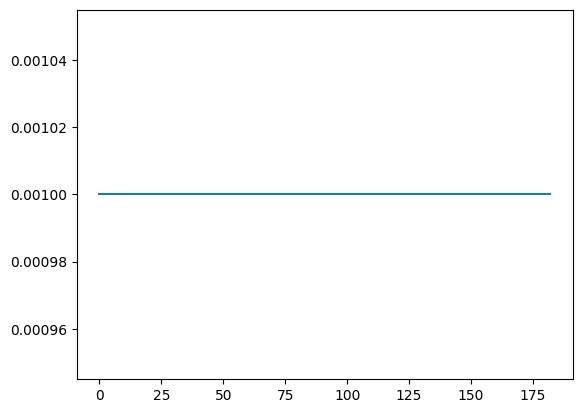

In [61]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

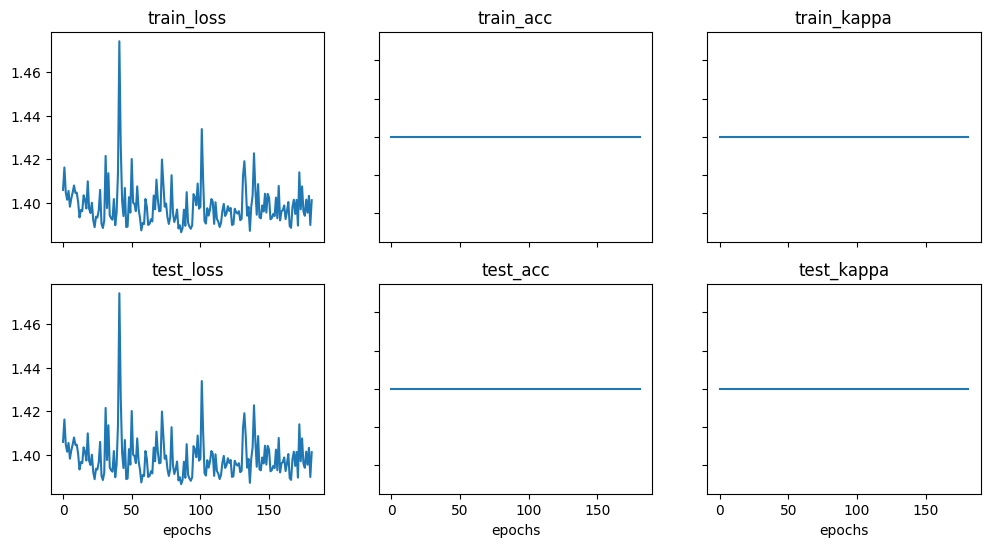

In [62]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

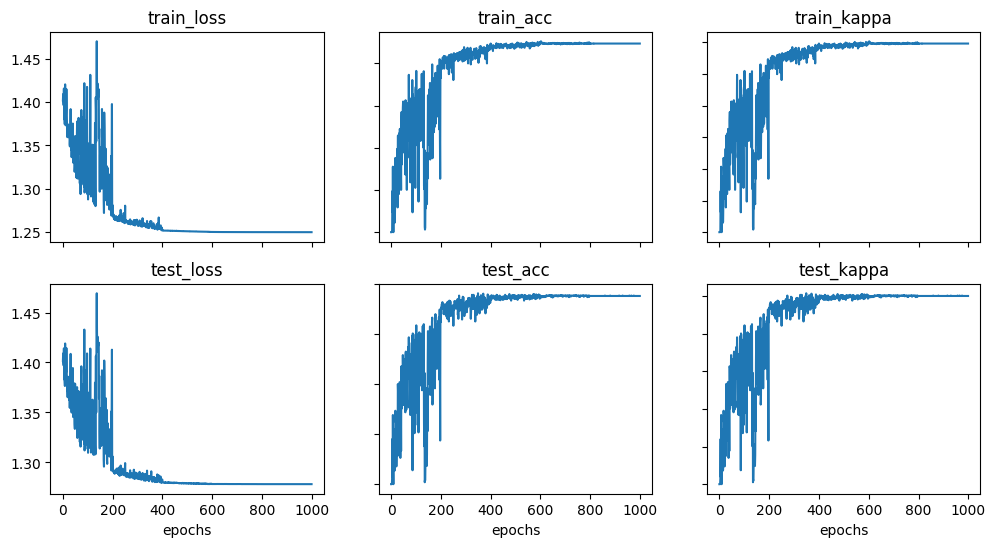

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()